# Sprint1　【問題4】高い汎化性能のモデル作成

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['installments_payments.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'bureau.csv', 'application_test.csv', 'application_train.csv', 'POS_CASH_balance.csv', 'sample_submission.csv', 'previous_application.csv']


## アンサンブル学習
複数のモデル（学習器）を融合させて1つの学習モデルを生成する手法．次の３つの手法非大別される．（スタッキングは今回省くけど．）
### バギング
アンサンブルを構成する個々の分類器の学習に，同じトレーニングデータを使用せず，ランダムに復元抽出したデータで学習する．予測値は多数決により決める．ブースティングと違い，並列的に学習していく．例）ランダムフォレスト
### ブースティング
１回目の学習の結果，誤分類されたサンプルの重みを大きく，正しく分類されたサンプルの重みは小さくして，次の学習データに反映させていく方法．＝今回使うLightGBM

# データ作成

In [2]:
# LightGBMをインポート
import lightgbm as lgb

In [3]:
# データの読み込み
features = pd.read_csv('../input/application_train.csv')
test = pd.read_csv('../input/application_test.csv')

In [4]:
# trainとtestを結合する
features['train_test_FLG'] = 0
test['train_test_FLG'] = 1
t_t = pd.concat([features,test],sort=False)

In [5]:
from sklearn.preprocessing import LabelEncoder
# ラベルエンコーダーをインスタンス化
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in t_t:
    if t_t[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(t_t[col].unique())) <= 2:
            # Train on the training data
            le.fit(t_t[col])
            # Transform both training and test_data2ing data
            t_t[col] = le.transform(t_t[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)
print('Features shape: ', t_t.shape)

3 columns were label encoded.
Features shape:  (356255, 123)


In [6]:
# one-hotエンコーディング（１列目は削除）
t_t_dummy = pd.get_dummies(t_t,drop_first=True)
print('Features shape: ', t_t.shape)


Features shape:  (356255, 123)


In [7]:
# trainとtestに戻す
train_data = t_t_dummy[t_t_dummy['train_test_FLG'] == 0].drop(['train_test_FLG','SK_ID_CURR'],axis=1)
test_data = t_t_dummy[t_t_dummy['train_test_FLG'] == 1].drop(['train_test_FLG','SK_ID_CURR'],axis=1)

In [8]:
train_data.head()

,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,1.0,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,0,0,0,0,0,0,1,0,0
1,0.0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0,0,0,0,0,0,0,0,0,0


In [9]:
test_data.head()

,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,NaN,0,0,1,0,135000.0,568800.0,20560.5,450000.0,0.018850,...,0,0,0,0,0,0,0,1,0,0
1,NaN,0,0,1,0,99000.0,222768.0,17370.0,180000.0,0.035792,...,0,0,0,0,0,0,0,0,0,0
2,NaN,0,1,1,0,202500.0,663264.0,69777.0,630000.0,0.019101,...,0,0,0,0,0,0,0,0,0,0
3,NaN,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,...,0,0,0,0,0,0,1,0,0,0
4,NaN,0,1,0,1,180000.0,625500.0,32067.0,625500.0,0.010032,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# testデータにTARGETができてしまったので，削除
test_features = test_data.drop('TARGET',axis=1)
test_features.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,0,0,1,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,...,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,...,0,0,0,0,0,0,1,0,0,0
4,0,1,0,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# trainデータを特徴量と目的変数に分ける
train_features = train_data.drop('TARGET',axis=1).values
train_labels = np.array(train_data['TARGET'].astype(np.int32)).reshape((-1, ))

## Earry Stopping
* 学習時に，何らかの指標（たぶん損失関数とか）を監視して，学習を終了させるテクニック．
* その指標が改善しなくなった時点で学習を終了させることで，過学習を防止する．

In [12]:
# LightGBM用のデータセットを作成する
train_set = lgb.Dataset(data = train_features, label = train_labels)

In [13]:
# クロスバリデーションの回数
N_FOLDS = 5
MAX_EVALS = 5



# LightGBMのインスタンス化
model = lgb.LGBMClassifier()

# LightGBMのハイパーパラメータのデフォルト値
default_params = model.get_params()
# クロスバリデーションのパラメータnum_boost_roundと同じなのでn_estimatorsは削除する
del default_params['n_estimators']

# Cross validation with early stopping
cv_results = lgb.cv(default_params, train_set, num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS, seed = 42)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


### n_estimatorsをグリッドサーチしても無駄な件．
n_estimatorsを５とした場合，途中の２や３のスコアも分かるから．num_boost_roundを大きめに設定しておけばよい．                                   　　　　　　　　　　　　　　　
ちなみに，LightGBMの内部的には、多クラス分類問題のためにnum_boost_roundに設定された数の木を作っていくので，n_estimatorsと同じ意味だから今回は消した．                  

In [14]:
# LightGBMのハイパーパラメータのデフォルト値を確認
default_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

**boosting_type**                             
gbdt、gbrt、rf、random_forest、dart、gossなどある．                                
gbdt（決定木を使ったブースティング．デフォルト．）                              
dart（ドロップアウトの考え方を利用している．）                               
 
**learning_rate**                      
デフォルトは0.1．結果に対する各ツリーの影響度を小さくする．n_estimatorsと反比例する．                  
                                
**subsample_for_bin**                                 
ヒストグラムビンを作成するためにサンプリングしたデータの数.default =200000         
これをより大きな値に設定すると、より良いトレーニング結果が得られるが，データロード時間が長くなる．                         
データが非常にまばらな場合は、これをより大きい値に設定する．             

**min_child_samples**                       
末端ノードに含まれる最小のデータ数．これを下回るような分割ルールでは分割されなくなる． 例えば 40 に設定すると，新しい分割を行ったあとの集合にデータ数が 40 を下回るようなルールでは分割できない．データの数にも依存するため, データ数が大きい時は少し大きい値にするのもよい．                     
                       
**num_leaves**                                  
各決定木の葉ノードの数（つまり１分岐が1回だと２個，２回だと３個）．高すぎると過学習，低すぎると未学習になる．                    
                                       
**max_depth**                                
各決定木の深さ．通常３～８くらい．深すぎると過学習になる．あまり単体で調整せず，たぶんmax_leavesと一緒に調整する．                  
                                   
**max_leaves**                                      
各木の末端ノードの数.ひとつの分割があるとノードは2つ、もう一回分割が起こるとノードは3になる．（分割数 + 1 だけ末端ノードは生成される）                 
max_depth を指定すると、最大の末端ノード数は 2 ** max_depth で制限されるため.(二分分割が depth だけ起こるので)                      
                                 
**n_n_estimators**                   
決定木の数                           
**reg_alphaとreg_lambda**                                       
わからない．                            
                                     
**colsample_bytree**                                       
???                                     
                              
**min_child_weight**                                              
？？？                              
                  
**subsample**                                              
各決定木内での副次標本率．普通0.8                     
                               
**colsample_bytree**                                                         
？？？                                            
                                     
**is_unbalance**                                                        
TrueかFalse．true訓練データのバランスが取れていない場合は、これをに設定．           
注：これを有効にすると、モデルの全体的なパフォーマンス測定基準が向上するが、個々のクラスの確率の推定値が悪くなる．                         

In [15]:
print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('The optimal number of boosting rounds (estimators) was {}.'.format(len(cv_results['auc-mean'])))

The maximum validation ROC AUC was: 0.75597 with a standard deviation of 0.00375.
The optimal number of boosting rounds (estimators) was 145.


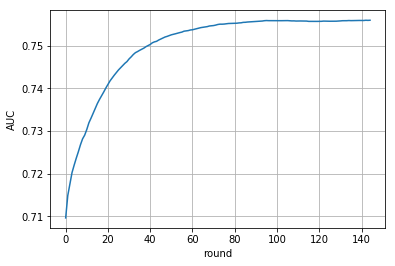

In [16]:
# AUCの動きを可視化してみる
import matplotlib.pyplot as plt
cv_n_estimators = cv_results['auc-mean']
round_n = np.arange(len(cv_n_estimators))
plt.xlabel('round')
plt.ylabel('AUC')
plt.plot(round_n,cv_n_estimators)
plt.grid()
plt.show()

100回目あたりから精度が変わらない．

In [17]:
model.n_estimators = len(cv_results['auc-mean'])
# Train and make predicions with model
model.fit(train_features, train_labels)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=145, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [18]:
# 推定
preds = model.predict_proba(test_features)
# 正解率
y_proba = model.predict_proba(test_features)

In [19]:
# 一連の流れを関数にしとく
# hyperparameters＝ハイパーパラメータ，iteration＝繰り返す回数
def objective(hyperparameters, iteration):    
    # early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
     # クロスバリデーション
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 42)
    
    # 一番良かったスコア
    score = cv_results['auc-mean'][-1]
    # その時の決定木の数
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    # 戻り値はベストAUCとその時のパラメータと
    return [score, hyperparameters, iteration]

In [20]:
# デフォルト値の結果
score, params, iteration = objective(default_params, 1)
print('The cross-validation ROC AUC was {:.5f}.'.format(score))

The cross-validation ROC AUC was 0.75597.


* ベイジアン最適化とは何か調べる．
* まず，ランダムサーチで広い範囲のパラメータを設定して，いい感じの値が見つかったら，範囲を狭めてグリッドサーチする
* 学習の進行状況をcsvに書き出しておくと，ノートブックを閉じても消えない（ただし途中でそのエクセルファイルを開かないこと！エラーになる）

# ランダムサーチ

In [21]:
# ランダムサーチするパラメータ
param_grid = {
    'boosting_type': ['gbdt'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'is_unbalance': [True, False]
}

boosting_typeがgossの場合、subsample（これは確率的勾配ブースティングとして知られている手法であるトレーニングデータの一部の行のみでのトレーニングを指す）を使用できない．計算コストも考慮し，今回は使用しないが，boosting_type = gossの場合、サブサンプルを1.0（すべての行を使用することを意味する）に設定すればいける．

In [22]:
import random
random.seed(50)

# 上で設定したパラメータを辞書型でランダムに取り出す．
random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
random_params

{'boosting_type': 'gbdt',
 'num_leaves': 88,
 'learning_rate': 0.027778881111994384,
 'subsample_for_bin': 220000,
 'min_child_samples': 175,
 'reg_alpha': 0.8979591836734693,
 'reg_lambda': 0.6122448979591836,
 'colsample_bytree': 0.8222222222222222,
 'is_unbalance': True}

In [23]:
# ランダムサーチ
def random_search(param_grid, max_evals = MAX_EVALS):
    # 結果はDataframeに
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    
    # MAX_EVALS数までサーチ
    for i in range(MAX_EVALS):
        
        # パラメータをランダムに辞書型で取り出す．
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}

        # ランダム洗濯されたパラメータで評価する
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
    
    #　スコアの高い順に並び替え
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results 

In [24]:
# 結果
random_results = random_search(param_grid)

print('The best validation score was {:.5f}'.format(random_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(random_results.loc[0, 'params'])

The best validation score was 0.76055

The best hyperparameters were:
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.8666666666666667,
 'is_unbalance': True,
 'learning_rate': 0.01217184436771555,
 'min_child_samples': 230,
 'n_estimators': 892,
 'num_leaves': 76,
 'reg_alpha': 0.7755102040816326,
 'reg_lambda': 0.7755102040816326,
 'subsample_for_bin': 40000}


boostigがdartの場合，Early stopping できないという警告が出たので，パラメータから消すことにした．              

In [25]:
# ベストスコアの取得
random_search_params = random_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**random_search_params, random_state = 42)
model.fit(train_features, train_labels)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.8666666666666667, importance_type='split',
               is_unbalance=True, learning_rate=0.01217184436771555,
               max_depth=-1, min_child_samples=230, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=892, n_jobs=-1, num_leaves=76,
               objective=None, random_state=42, reg_alpha=0.7755102040816326,
               reg_lambda=0.7755102040816326, silent=True, subsample=1.0,
               subsample_for_bin=40000, subsample_freq=0)

In [26]:
# ベストモデルでTARGET1の正解率を計算
preds = model.predict_proba(test_features)[:, 1]

In [27]:
# スコアとパラメータの推移
random_results

,index,score,params,iteration
0,1,0.760548,"{'boosting_type': 'gbdt', 'num_leaves': 76, 'l...",1
1,4,0.757043,"{'boosting_type': 'gbdt', 'num_leaves': 89, 'l...",4
2,0,0.755494,"{'boosting_type': 'gbdt', 'num_leaves': 77, 'l...",0
3,3,0.753783,"{'boosting_type': 'gbdt', 'num_leaves': 131, '...",3
4,2,0.75258,"{'boosting_type': 'gbdt', 'num_leaves': 105, '...",2


In [28]:
# ベストパラメータ
random_search_params

{'boosting_type': 'gbdt',
 'num_leaves': 76,
 'learning_rate': 0.01217184436771555,
 'subsample_for_bin': 40000,
 'min_child_samples': 230,
 'reg_alpha': 0.7755102040816326,
 'reg_lambda': 0.7755102040816326,
 'colsample_bytree': 0.8666666666666667,
 'is_unbalance': True,
 'n_estimators': 892}

# 【問題5】最終的なモデルの選定

In [29]:
# 新しいデータフレームを作って，提出する列のみ残して，csvに吐き出す
df_out = pd.read_csv('../input/application_test.csv')
df_out['TARGET'] = preds
predict_result1 = df_out[['SK_ID_CURR','TARGET']]
predict_result1.to_csv("predict_results1.csv",index=False)